# Customer Churn Prediction
<i>Last Update: 19/03/2024</i><br>
<i>Python Version: 3.11.1</i><br>
<i>Author: W.P.Roshan</i><br>
<i>Email: sunone5@gmail.com</i>

![](https://res.cloudinary.com/dn1j6dpd7/image/fetch/f_auto,q_auto,w_736/https://www.livechat.com/wp-content/uploads/2016/04/customer-churn@2x.jpg)

In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# Plots
from plotly.offline import iplot
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px #for visualization
import matplotlib.pyplot as plt #for visualization 
%matplotlib inline

import os
import warnings
warnings.filterwarnings("ignore")
PATH = os.getcwd()+os.sep
RANDOM_SEED = 142
K_FOLDS = 5

In [2]:
df = pd.read_csv("./../data/telco_customer_churn_data.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
#Get overview of the data
def dataoveriew(df, message):
    print(f'{message}:n')
    print('Number of rows: ', df.shape[0])
    print("Number of features:", df.shape[1])
    print("Data Features:")
    print(df.columns.tolist())
    print("Missing values:", df.isnull().sum().values.sum())
    print("NAN values:", df.isna().sum().values.sum())
    print("Unique values:")
    print(df.nunique())

In [4]:
dataoveriew(df, 'Overview of the dataset')

Overview of the dataset:n
Number of rows:  7043
Number of features: 21
Data Features:
['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']
Missing values: 0
NAN values: 0
Unique values:
customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


1. The data doesn't have null values and the column Total Charge is not float.
2. SeniorCitizen = older than 65 
3. Tenure in Months: Indicates the total amount of months that the customer has been with the company by the end of the quarter specified above.

In [6]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


1. Average Monthly charge = 64.761692
2. Minimum Monthly charge = 18.250000
3. Maximum Monthly charge = 118.75000

In [7]:
target_instance = df["Churn"].value_counts().to_frame()
target_instance = target_instance.reset_index()
target_instance = target_instance.rename(columns={'index': 'Category'})
fig = px.pie(target_instance, values='count', names='Churn', color_discrete_sequence=["dodgerblue", "deeppink"],
             title='Distribution of Churn')
fig.show()

We’re trying to predict users that left the company in the previous month. It’s a binary classification problem with an unbalanced target.<br>

Churn: No – 73.5%<br>
Churn: Yes – 26.5%<br>
Let’s explore categorical features.

In [8]:
#Defining bar chart function
def bar(feature, df=df ):
    #Groupby the categorical feature
    temp_df = df.groupby([feature, 'Churn']).size().reset_index()
    temp_df = temp_df.rename(columns={0:'Count'})    
    #SeniorCitizen feature plot 
    #df.loc[df.SeniorCitizen==0,'SeniorCitizen'] = "No"   #convert 0 to No in all data instances
    #df.loc[df.SeniorCitizen==1,'SeniorCitizen'] = "Yes"  #convert 1 to Yes in all data instances       
    #Calculate the value counts of each distribution and it's corresponding Percentages
    value_counts_df = df[feature].value_counts().to_frame().reset_index()
    categories = [cat[1][0] for cat in value_counts_df.iterrows()]
    #Calculate the value counts of each distribution and it's corresponding Percentages
    num_list = [num[1][1] for num in value_counts_df.iterrows()]
    div_list = [element / sum(num_list) for element in num_list]
    percentage = [round(element * 100,1) for element in div_list]
    #Defining string formatting for graph annotation
    #Numeric section
    def num_format(list_instance):
        formatted_str = ''
        for index,num in enumerate(list_instance):
            if index < len(list_instance)-2:
                formatted_str=formatted_str+f'{num}%, ' #append to empty string(formatted_str)
            elif index == len(list_instance)-2:
                formatted_str=formatted_str+f'{num}% & '
            else:
                formatted_str=formatted_str+f'{num}%'
        return formatted_str
    #Categorical section
    def str_format(list_instance):
        formatted_str = ''
        for index, cat in enumerate(list_instance):
            if index < len(list_instance)-2:
                formatted_str=formatted_str+f'{cat}, '
            elif index == len(list_instance)-2:
                formatted_str=formatted_str+f'{cat} & '
            else:
                formatted_str=formatted_str+f'{cat}'
        return formatted_str
    #Running the formatting functions
    num_str = num_format(percentage)
    cat_str = str_format(categories)

    #Setting graph framework
    fig = px.bar(temp_df, x=feature, y='Count', color='Churn', title=f'Churn rate by {feature}', barmode="group", color_discrete_sequence=["dodgerblue", "deeppink"])
    fig.add_annotation(
                text=f'Value count of distribution of {cat_str} are<br>{num_str} percentage respectively.',
                align='left',
                showarrow=False,
                xref='paper',
                yref='paper',
                x=1.4,
                y=1.3,
                bordercolor='black',
                borderwidth=1)
    fig.update_layout(
        # margin space for the annotations on the right
        margin=dict(r=450),
    )

    return fig.show()

Now, let’s plot the demographic features.

In [9]:
#Gender feature plot
bar('gender')
#SeniorCitizen feature plot 
df.loc[df.SeniorCitizen==0,'SeniorCitizen'] = "No"   #convert 0 to No in all data instances
df.loc[df.SeniorCitizen==1,'SeniorCitizen'] = "Yes"  #convert 1 to Yes in all data instances
bar('SeniorCitizen')
#Partner feature plot
bar('Partner')
#Dependents feature plot
bar('Dependents')

<b>Demographic analysis insight</b>: Gender and partner are evenly distributed with approximate percentage values. The difference in churn is slightly higher in females, but the small difference can be ignored. There’s a higher proportion of churn in younger customers (SeniorCitizen = No), customers with no partners, and customers with no dependents. The demographic section of data highlights on-senior citizens with no partners and dependents as a particular segment of customers likely to churn.

Next, let’s explore the services that each customer has signed up for.

In [10]:
bar('PhoneService')
bar('MultipleLines')
bar('InternetService')
bar('OnlineSecurity')
bar('OnlineBackup')
bar('DeviceProtection')
bar('TechSupport')
bar('StreamingTV')
bar('StreamingMovies')

<b>Services that each customer has signed up for insight</b>: These features show significant variations across their values. If a customer doesn’t have phone service, they can’t have multiple lines. About 90.3% of the customers have phone services and have a higher rate to churn. Customers who have fibre optic as an internet service are more likely to churn. This can happen due to high prices, competition, customer service, and many other reasons. Fiber optic service is much more expensive than DSL, which may be one of the reasons why customers churn. Customers with  OnlineSecurity, OnlineBackup, DeviceProtection, and TechSupport are more unlikely to churn. Streaming service is not predictive for churn as it’s evenly distributed to yes and no options.

Time to explore payment features.

In [11]:
bar('Contract')
bar('PaperlessBilling')
bar('PaymentMethod')

<b>Payment insights</b>: The shorter the contract, the higher the churn rate. Those with more extended plans face additional barriers when canceling early. This clearly explains the motivation for companies to have long-term relationships with their customers. Churn Rate is higher for the customers who opted for paperless billing. About 59.2% of customers use paperless billing. Customers who pay with electronic checks are more likely to churn, and this kind of payment is more common than other payment types.

Now, let’s explore numeric features.

In [12]:
df.dtypes

customerID           object
gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

It can be observed that the TotalCharges has an object data type which means that it contains string components. Let’s convert it.

In [13]:
# Let’s catch the error
try:
    df['TotalCharges'] = df['TotalCharges'].astype(float)
except ValueError as ve:
    print (ve)

could not convert string to float: ' '


This indicates that some empty values are stored as empty spaces. Let’s transform the feature into a numerical format while equating these empty string spaces as NaN as follows:

In [14]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'],errors='coerce')
#Fill the missing values with with the median value
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
print(f"The Feature TotalCharges is type {df.TotalCharges.dtype} now!")

The Feature TotalCharges is type float64 now!


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


#### We already converted SeniorCitizen into String format to show lebels on the Plot.<br/>Againg we need convert it back to int64 format.

In [16]:
# Let’s catch the error
try:
    #df['SeniorCitizen'] = df['SeniorCitizen'].astype(np.int64)
    df['SeniorCitizen'] = pd.to_numeric(df['SeniorCitizen'],errors='coerce').astype(np.int64)
except ValueError as ve:
    print (ve)

Cannot convert non-finite values (NA or inf) to integer


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [18]:
print("Missing values:", df.isnull().sum().values.sum())
print("NAN values:", df.isna().sum().values.sum())

Missing values: 0
NAN values: 0


Let see the overview of this dataset again

In [19]:
dataoveriew(df, 'Overview of the dataset')

Overview of the dataset:n
Number of rows:  7043
Number of features: 21
Data Features:
['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']
Missing values: 0
NAN values: 0
Unique values:
customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64


Next, let’s <b>plot the histogram</b> of all the numeric features to understand the distribution.

In [20]:
# Defining the histogram plotting function
def hist(feature):
    group_df = df.groupby([feature, 'Churn']).size().reset_index()
    group_df = group_df.rename(columns={0: 'Count'})
    fig = px.histogram(group_df, x=feature, y='Count', color='Churn', marginal='box', title=f'Churn rate frequency to {feature} distribution', color_discrete_sequence=["dodgerblue", "deeppink"])
    fig.show()

In [21]:
hist('tenure')
hist('MonthlyCharges')
hist('TotalCharges')

<b>Customer account information insight:</b> The tenure histogram is rightly skewed and shows that most customers have been with the telecom company for just the first few months (0-9 months). The highest rate of churn is also in the first few months (0-9months). 75% of customers who end up leaving the Telco company do so within their first 30 months. The monthly charge histogram shows that clients with higher monthly charges have a higher churn rate. This suggests that discounts and promotions can be an enticing reason for customers to stay.

Let’s bin the numeric features into three sections based on quantiles (low, medium, and high to get more information from it).

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [23]:
#Create an empty dataframe
bin_df = pd.DataFrame()

#Update the binning dataframe
bin_df['tenure_bins'] =  pd.qcut(df['tenure'], q=3, labels= ['low', 'medium', 'high'])
bin_df['MonthlyCharges_bins'] =  pd.qcut(df['MonthlyCharges'], q=3, labels= ['low', 'medium', 'high'])
bin_df['TotalCharges_bins'] =  pd.qcut(df['TotalCharges'], q=3, labels= ['low', 'medium', 'high'])
bin_df['Churn'] = df['Churn']

#Plot the bar chart of the binned variables
bar('tenure_bins', bin_df)
bar('MonthlyCharges_bins', bin_df)
bar('TotalCharges_bins', bin_df)

#### Based on binning, the low tenure and high monthly charge bins have higher churn rates, as supported by the previous analysis. At the same time, the low Total charge bin has a higher churn rate. 

Make a random sample of 10% size of the dataset will be get to make predictions with unseen data.

In [24]:
# Dataset Sampling
def data_sampling(dataset, frac: float, random_seed: int):
    data_sampled_a = dataset.sample(frac=frac, random_state=random_seed)
    data_sampled_b =  dataset.drop(data_sampled_a.index).reset_index(drop=True)
    data_sampled_a.reset_index(drop=True, inplace=True)
    return data_sampled_a, data_sampled_b  

In [25]:
data, data_unseen = data_sampling(df, 0.9, RANDOM_SEED)
print(f"There are {data_unseen.shape[0]} samples for Unseen Data.")

There are 704 samples for Unseen Data.


In [26]:
data_unseen.to_csv('./../data/data_unseen.csv', index=False, encoding='utf-8')

# Data preprocessing

In this section, we’ll gain more insights and convert the data into a data representation suitable for various machine learning algorithms.

In [27]:
# The customerID column isnt useful as the feature is used for identification of customers. 
data.drop(["customerID"],axis=1,inplace = True)

# Encode categorical features

#Defining the map function
def binary_map(feature):
    return feature.map({'Yes':1, 'No':0})

## Encoding target feature
data['Churn'] = data[['Churn']].apply(binary_map)

# Encoding gender category
data['gender'] = data['gender'].map({'Male':1, 'Female':0})

#Encoding other binary category
binary_list = ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
data[binary_list] = data[binary_list].apply(binary_map)

#Encoding the other categoric features with more than two categories
data = pd.get_dummies(data, drop_first=True)

#### Let’s see the correlation between values.

The heatmap displays the correlation between numeric features in the dataset.

Understanding feature correlations can help in feature selection. For instance, if MonthlyCharges and TotalCharges are highly correlated, you might choose to keep only one of them to avoid multicollinearity in your models. It also helps identify which features might be more important in predicting churn.

In [28]:
# Checking the correlation between features
corr = data.corr(method='pearson', min_periods=1)
fig = px.imshow(corr.T,width=1000, height=1000, color_continuous_scale='RdBu_r', origin='lower')
fig.show()

Correlation measures the linear relationship between two variables. Features with high correlation are more linearly dependent and have almost the same effect on the dependent variable. So, when two features have a high correlation, we can drop one of them. In our case, we can drop highly correlated features like MultipleLines, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, and StreamingMovies.

Churn prediction is a binary classification problem, as customers either churn or are retained in a given period. Two questions need answering to guide model building:

1. Which features make customers churn or retain?</br>
2. What are the most important features to train a model with high performance?</br></br>
Let’s <b>use the generalized linear model (GLM)</b> to gain some statistics of the respective features with the target.

In [29]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

#Change variable name separators to '_'
all_columns = [column.replace(" ", "_").replace("(", "_").replace(")", "_").replace("-", "_") for column in data.columns]

#Effect the change to the dataframe column names
data.columns = all_columns

#Prepare it for the GLM formula
glm_columns = [e for e in all_columns if e not in ['customerID', 'Churn']]
glm_columns = ' + '.join(map(str, glm_columns))

#Fiting it to the Generalized Linear Model
glm_model = smf.glm(formula=f'Churn ~ {glm_columns}', data=data, family=sm.families.Binomial())
res = glm_model.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Churn   No. Observations:                 6339
Model:                            GLM   Df Residuals:                     6315
Model Family:                Binomial   Df Model:                           23
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2649.5
Date:                Tue, 19 Mar 2024   Deviance:                       5299.0
Time:                        21:03:40   Pearson chi2:                 6.94e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2791
Covariance Type:            nonrobust                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------

For the first , you should look at the (P>|z|) column. If the absolute p-value is smaller than 0.05, it means that the feature affects Churn in a statistically significant way. Examples are:

* SeniorCitizen
* Tenure
* Contract
* PaperlessBillings etc.<br/><br/>
The second , about feature importances can be answered by looking at the exponential coefficient values. The exponential coefficient estimates the expected change in churn through a given feature by a change of one unit.

In [30]:
#  The exponential coefficient estimates
np.exp(res.params)

Intercept                                        2.500029
MultipleLines_No_phone_service[T.True]           1.393491
MultipleLines_Yes[T.True]                        1.591601
InternetService_Fiber_optic[T.True]              6.299689
InternetService_No[T.True]                       0.771280
OnlineSecurity_No_internet_service[T.True]       0.771280
OnlineSecurity_Yes[T.True]                       0.853544
OnlineBackup_No_internet_service[T.True]         0.771280
OnlineBackup_Yes[T.True]                         1.120299
DeviceProtection_No_internet_service[T.True]     0.771280
DeviceProtection_Yes[T.True]                     1.186793
TechSupport_No_internet_service[T.True]          0.771280
TechSupport_Yes[T.True]                          0.841720
StreamingTV_No_internet_service[T.True]          0.771280
StreamingTV_Yes[T.True]                          1.948705
StreamingMovies_No_internet_service[T.True]      0.771280
StreamingMovies_Yes[T.True]                      1.931558
Contract_One_y

##### This outputs the odd ratios. Values more than 1 indicate increased churn. Values less than 1 indicate that churn is happening less.

##### The range of all features should be normalized so that each feature contributes approximately proportionately to the final distance, so we do feature scaling.

# Feature Scaling

In [31]:
#feature scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
data['tenure'] = sc.fit_transform(data[['tenure']])
data['MonthlyCharges'] = sc.fit_transform(data[['MonthlyCharges']])
data['TotalCharges'] = sc.fit_transform(data[['TotalCharges']])

# Baseline Model Training

#### Let’s start creating a baseline model with a 
<b>Logistic Regression Algorithm</b>, then predict with other machine learning models like<br/> 
<b>Support Vector Classifier (SVC)</b>,<br/> 
<b>Random Forest Classifier</b>,<br/> 
<b>Decision-tree classifier</b>, and<br/> 
<b>Naive-Bayes Classifier</b>.<br/>
<b>Gradient Boosting Classifier</b>.<br/>
<b>Extreme Gradient Boosting Classifier</b>.<br/>

In [32]:
# Import Machine learning algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

#Import metric for performance evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc

#Split data into train and test sets
from sklearn.model_selection import train_test_split
X = data.drop('Churn', axis=1)
y = data['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)

#Defining the modelling function
def modeling(alg, alg_name, params={}):
    model = alg(**params) #Instantiating the algorithm class and unpacking parameters if any
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    #Performance evaluation
    def print_scores(alg, y_true, y_pred):
        print(alg_name)
        acc_score = accuracy_score(y_true, y_pred)
        print("accuracy: ",acc_score)
        pre_score = precision_score(y_true, y_pred)
        print("precision: ",pre_score)
        rec_score = recall_score(y_true, y_pred)
        print("recall: ",rec_score)
        f_score = f1_score(y_true, y_pred, average='weighted')
        print("f1_score: ",f_score)

    print_scores(alg, y_test, y_pred)
    return model

# Running logistic regression model
logistic_regression_model = modeling(LogisticRegression, 'Logistic Regression')

Logistic Regression
accuracy:  0.7996845425867508
precision:  0.6348448687350835
recall:  0.5384615384615384
f1_score:  0.7940552587256205


<b>Next, we do feature selection</b> to enable the machine learning algorithm to train faster, reduce model complexity, increase interpretability, and improve model accuracy if the right features subset is chosen.

# Feature Selection

### Recursive Feature Elimination (RFE) with Cross Validation plot

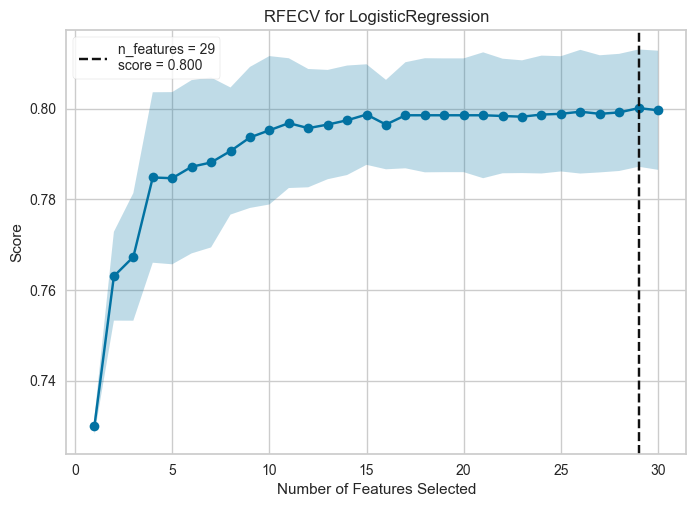

<Axes: title={'center': 'RFECV for LogisticRegression'}, xlabel='Number of Features Selected', ylabel='Score'>

In [33]:
from yellowbrick.model_selection import RFECV
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(10, random_state=50, shuffle=True)
visualizer = RFECV(LogisticRegression(), cv=cv, step=1, scoring='accuracy')

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

In [46]:
#Saving dataframe with optimal features
X_rfe = X.iloc[:, visualizer.support_]
X_rfe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6339 entries, 0 to 6338
Data columns (total 29 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   gender                                 6339 non-null   int64  
 1   SeniorCitizen                          6339 non-null   int64  
 2   Dependents                             6339 non-null   int64  
 3   tenure                                 6339 non-null   float64
 4   PhoneService                           6339 non-null   int64  
 5   PaperlessBilling                       6339 non-null   int64  
 6   MonthlyCharges                         6339 non-null   float64
 7   TotalCharges                           6339 non-null   float64
 8   MultipleLines_No_phone_service         6339 non-null   bool   
 9   MultipleLines_Yes                      6339 non-null   bool   
 10  InternetService_Fiber_optic            6339 non-null   bool   
 11  Inte

In [47]:
dataoveriew(X_rfe, 'Overview of the dataset')

Overview of the dataset:n
Number of rows:  6339
Number of features: 29
Data Features:
['gender', 'SeniorCitizen', 'Dependents', 'tenure', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'MultipleLines_No_phone_service', 'MultipleLines_Yes', 'InternetService_Fiber_optic', 'InternetService_No', 'OnlineSecurity_No_internet_service', 'OnlineSecurity_Yes', 'OnlineBackup_No_internet_service', 'OnlineBackup_Yes', 'DeviceProtection_No_internet_service', 'DeviceProtection_Yes', 'TechSupport_No_internet_service', 'TechSupport_Yes', 'StreamingTV_No_internet_service', 'StreamingTV_Yes', 'StreamingMovies_No_internet_service', 'StreamingMovies_Yes', 'Contract_One_year', 'Contract_Two_year', 'PaymentMethod_Credit_card__automatic_', 'PaymentMethod_Electronic_check', 'PaymentMethod_Mailed_check']
Missing values: 0
NAN values: 0
Unique values:
gender                                      2
SeniorCitizen                               2
Dependents                                  2
te

In [45]:

X_rfe.to_csv('./../data/data_rfecv.csv', index=False, encoding='utf-8')

#Overview of the optimal features in comparison with the intial dataframe
print("\"X\" dimension: {}".format(X.shape))
print("\"X\" column list:", X.columns.tolist())
print("\"X_rfe\" dimension: {}".format(X_rfe.shape))
print("\"X_rfe\" column list:", X_rfe.columns.tolist())

"X" dimension: (6339, 30)
"X" column list: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'MultipleLines_No_phone_service', 'MultipleLines_Yes', 'InternetService_Fiber_optic', 'InternetService_No', 'OnlineSecurity_No_internet_service', 'OnlineSecurity_Yes', 'OnlineBackup_No_internet_service', 'OnlineBackup_Yes', 'DeviceProtection_No_internet_service', 'DeviceProtection_Yes', 'TechSupport_No_internet_service', 'TechSupport_Yes', 'StreamingTV_No_internet_service', 'StreamingTV_Yes', 'StreamingMovies_No_internet_service', 'StreamingMovies_Yes', 'Contract_One_year', 'Contract_Two_year', 'PaymentMethod_Credit_card__automatic_', 'PaymentMethod_Electronic_check', 'PaymentMethod_Mailed_check']
"X_rfe" dimension: (6339, 29)
"X_rfe" column list: ['gender', 'SeniorCitizen', 'Dependents', 'tenure', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'MultipleLines_No_phone_service', 'MultipleLin

### Splitting data with optimal features

In [35]:
# Splitting data with optimal features
X_train, X_test, y_train, y_test = train_test_split(X_rfe, y, test_size=0.3, random_state=50)  

In [36]:
# Running logistic regression model
logit_model = modeling(LogisticRegression, 'Logistic Regression Classification')

Logistic Regression Classification
accuracy:  0.7991587802313355
precision:  0.6333333333333333
recall:  0.5384615384615384
f1_score:  0.7935997699643897


### Trying other machine learning algorithms

In [37]:
### Trying other machine learning algorithms: SVC
svc_model = modeling(SVC, 'SVC Classification')

SVC Classification
accuracy:  0.7949526813880127
precision:  0.6375661375661376
recall:  0.48785425101214575
f1_score:  0.7853704013791574


In [38]:
#Random forest
rf_model = modeling(RandomForestClassifier, "Random Forest Classification")

Random Forest Classification
accuracy:  0.7860147213459516
precision:  0.616
recall:  0.4676113360323887
f1_score:  0.77570128725554


In [39]:
#Decision tree
dt_model = modeling(DecisionTreeClassifier, "Decision Tree Classification")

Decision Tree Classification
accuracy:  0.7087276550998949
precision:  0.4460431654676259
recall:  0.5020242914979757
f1_score:  0.7140484595910257


In [40]:
#Naive bayes 
nb_model = modeling(GaussianNB, "Naive Bayes Classification")

Naive Bayes Classification
accuracy:  0.6572029442691903
precision:  0.4213147410358566
recall:  0.8562753036437247
f1_score:  0.6776493751167894


In [41]:
#Gradient Boosting 
gb_model = modeling(GradientBoostingClassifier, "Gradient Boosting Classification")

Gradient Boosting Classification
accuracy:  0.7960042060988434
precision:  0.6331658291457286
recall:  0.5101214574898786
f1_score:  0.7883894219920023


In [42]:
#XGBoost 
xgb_model = modeling(XGBClassifier, "Extreme Gradient Boosting Classification")

Extreme Gradient Boosting Classification
accuracy:  0.7870662460567823
precision:  0.5982339955849889
recall:  0.548582995951417
f1_score:  0.783984679731923


From the selected performance metrics, the Logistic Regression algorithm has the highest scores across all chosen metrics. It can be improved with various techniques, but we’ll quickly <b>improve it with hyperparameter tuning</b> (Random search).

# Hyperparameter Tuning 

#### with RepeatedStratifiedKFold and RandomizedSearchCV

In [43]:
## Improve best model by hyperparameter tuning
# define model
model = LogisticRegression()

# define evaluation
from sklearn.model_selection import RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define search space
from scipy.stats import loguniform
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = loguniform(1e-5, 1000)

# define search
from sklearn.model_selection import RandomizedSearchCV
search = RandomizedSearchCV(model, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)

# execute search
result = search.fit(X_rfe, y)
# summarize result
# print('Best Score: %s' % result.best_score_)
# print('Best Hyperparameters: %s' % result.best_params_)
params = result.best_params_

#Improving the Logistic Regression model
log_model = modeling(LogisticRegression, 'Logistic Regression Classification', params=params)

Logistic Regression Classification
accuracy:  0.8017875920084122
precision:  0.6382978723404256
recall:  0.5465587044534413
f1_score:  0.7965514755502505


The model improved slightly. Let’s save the model and start the deployment of our churn prediction application using this model.

In [44]:
#Saving best model 
import joblib
#Sava the model to disk
import os
PATH = os.getcwd()+os.sep
filename = os.path.join(PATH, './../models/model.joblib')
joblib.dump(log_model, filename)

['d:\\Python_Projects\\telco_churn_prediction_streamlit\\notebook\\./../models/model.joblib']